Load the dataset from HuggingFace website .

In [3]:
from datasets import load_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report


In [4]:
ds = load_dataset("wangrongsheng/ag_news")

## Dataset Overview

The dataset consists of **two splits**:

1. **Train dataset**: Contains **120,000 rows**  
2. **Test dataset**: Contains **7,600 rows**

The split proportions are approximately:  
- Train set: **94%** of the whole dataset  
- Test set: **6%** of the whole dataset  

---

## Dataset Features

The dataset has **two features**:

| Feature | Description                                |
|---------|--------------------------------------------|
| **text**  | The input to our model — news headlines (strings)  |
| **label** | The target output — integers representing news categories |

---

## Label Mapping

| Label | Category           |
|-------|--------------------|
| 0     | World              |
| 1     | Sports             |
| 2     | Business           |
| 3     | Science / Technology |


In [5]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

Now I put the train dataset and test dataset in two seperates dataframes .

In [6]:
train_df = pd.DataFrame(ds['train'])
test_df = pd.DataFrame(ds['test'])


In [7]:
train_df['text'].head()

0    Wall St. Bears Claw Back Into the Black (Reute...
1    Carlyle Looks Toward Commercial Aerospace (Reu...
2    Oil and Economy Cloud Stocks' Outlook (Reuters...
3    Iraq Halts Oil Exports from Main Southern Pipe...
4    Oil prices soar to all-time record, posing new...
Name: text, dtype: object

As appear from info the data type of two columns is correct , text has object data type and label has integer data type , Two columns don't have null values .

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    120000 non-null  object
 1   label   120000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


As appears here the dataset is balanced and every label appears 30000 times .

In [9]:
train_df['label'].value_counts()

label
2    30000
3    30000
1    30000
0    30000
Name: count, dtype: int64

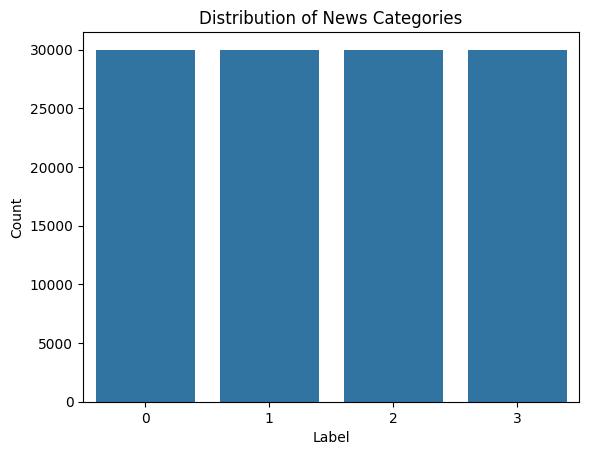

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=train_df)
plt.title("Distribution of News Categories")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


As appears here :
1. on average each headline has 38 words .
2. +-10 word variation from the mean.
3. The shortest headline is 8
4. The longest headline is 177

In [11]:
train_df['word_count'] = train_df['text'].apply(lambda x : len(x.split()))
train_df['word_count'].describe()

count    120000.000000
mean         37.847450
std          10.085245
min           8.000000
25%          32.000000
50%          37.000000
75%          43.000000
max         177.000000
Name: word_count, dtype: float64

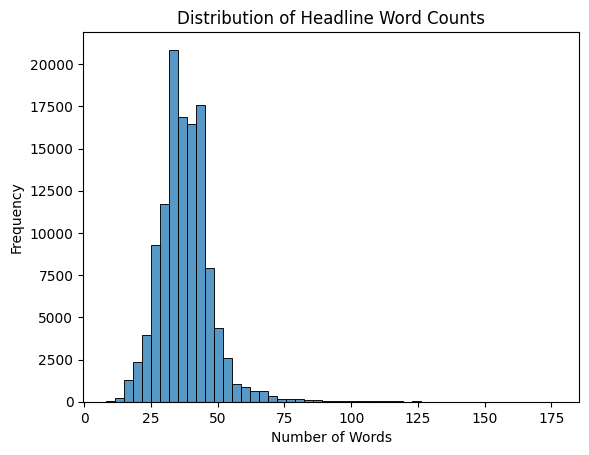

In [12]:
sns.histplot(train_df['word_count'], bins=50)
plt.title("Distribution of Headline Word Counts")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()



Here we do some explanation to know  which are the most frequent words in our dataset .(I can set max features as I want the number of most frequent words )

Now I want to check out the most frequent word for each category in my dataset , to give me an insight on these keywords that will help me specify the category of the news .

In [13]:
label_map ={
    0 : 'World',
    1 : 'Sports',
    2 : 'Business',
    3 : 'Sci/Tech'
}

In [14]:
train_df['category'] = train_df['label'].map(label_map)

In [15]:
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\b\d+\b', '', text)
    custom_stopwords = r'\b(reuters|said|39|quot|lt|gt|ap|afp|new|red|night)\b'
    text = re.sub(custom_stopwords, '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

In [16]:
top_words_per_label = {}
for label , group in train_df.groupby('category'):
    TF = TfidfVectorizer(stop_words='english',max_features=50, ngram_range=(1, 2))
    sub_X = TF.fit_transform(group['clean_text'])
    top_words = TF.get_feature_names_out()
    top_words_per_label[label] = top_words

In [17]:
for category, words in top_words_per_label.items():
    print(f"\nTop words for category: {category}")
    print(words)


Top words for category: Business
['bank' 'billion' 'business' 'buy' 'chief' 'company' 'corp' 'cut' 'deal'
 'dollar' 'earnings' 'economy' 'federal' 'friday' 'government' 'group'
 'growth' 'higher' 'investors' 'jobs' 'largest' 'maker' 'market' 'million'
 'monday' 'oil' 'oil prices' 'percent' 'prices' 'profit' 'quarter'
 'record' 'reported' 'research' 'rise' 'rose' 'sales' 'says' 'shares'
 'stock' 'stocks' 'thursday' 'tuesday' 'update' 'wednesday' 'week' 'world'
 'year' 'yesterday' 'york']

Top words for category: Sci/Tech
['announced' 'apple' 'business' 'companies' 'company' 'computer' 'corp'
 'digital' 'game' 'google' 'ibm' 'industry' 'intel' 'internet' 'linux'
 'market' 'microsoft' 'million' 'mobile' 'monday' 'music' 'nasa' 'online'
 'pc' 'phone' 'plans' 'says' 'scientists' 'search' 'security' 'service'
 'services' 'software' 'space' 'technology' 'thursday' 'time' 'today'
 'tuesday' 'users' 'version' 'video' 'web' 'wednesday' 'week' 'windows'
 'wireless' 'world' 'year' 'years']

Top w

In [18]:
TF = TfidfVectorizer(stop_words='english',max_features=5000,ngram_range=(1,2))
X_train = TF.fit_transform(train_df['clean_text'])
X_test = TF.transform(test_df['clean_text'])

In [19]:
y_train = train_df['label']
y_test = test_df['label']

In [20]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
preds = model.predict(X_test)
acc = accuracy_score(y_test, preds)

In [21]:
models  ={
    'LogisticRegression' : LogisticRegression(max_iter=1000),
    'DecisionTree' : DecisionTreeClassifier(),
    'KNN' : KNeighborsClassifier(n_neighbors=5),
    'GradientBoosting': GradientBoostingClassifier()
    
}

In [ ]:
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"{name} Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, preds, target_names=label_map.values()))